In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
import galsim
from pyHalo.preset_models import CDM
from copy import deepcopy
from lenstronomy.Util.correlation import power_spectrum_1d
from matplotlib.lines import Line2D
from lenstronomy.Plots import plot_util as len_plot_util

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.plots import plot_util
from mejiro.utils import util

In [2]:
ps_dir = os.path.join(data_dir, 'output', 'power_spectra_parallelized')
r = np.load(os.path.join(ps_dir, 'r.npy'))

Get subhalo mass functions

In [3]:
wdm_realizations = util.unpickle_all(ps_dir, 'wdm_realization_', '.pkl')
mdm_realizations = util.unpickle_all(ps_dir, 'mdm_realization_', '.pkl')
sdm_realizations = util.unpickle_all(ps_dir, 'sdm_realization_', '.pkl')
cdm_realizations = util.unpickle_all(ps_dir, 'cdm_realization_', '.pkl')

def get_bins_mean_std(realizations, num_bins):
    count_list = []

    for realization in realizations:
        cdm_halo_masses = [halo.mass for halo in realization.halos]
        count, bins = np.histogram(cdm_halo_masses, bins=np.logspace(6, 11, num_bins))
        count_list.append(count)

    return bins[:-1], np.mean(count_list, axis=0), np.std(count_list, axis=0)

bins_wdm_shmf, mean_wdm_shmf, std_wdm_shmf = get_bins_mean_std(wdm_realizations, 20)
bins_mdm_shmf, mean_mdm_shmf, std_mdm_shmf = get_bins_mean_std(mdm_realizations, 20)
bins_sdm_shmf, mean_sdm_shmf, std_sdm_shmf = get_bins_mean_std(sdm_realizations, 20)
bins_cdm_shmf, mean_cdm_shmf, std_cdm_shmf = get_bins_mean_std(cdm_realizations, 20)

Get power spectra of convergence maps

In [4]:
kappa_r = np.load(os.path.join(ps_dir, 'kappa_r.npy'))
kappa_ps_wdm = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_kappa_wdm_*.npy'))]
kappa_ps_mdm = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_kappa_mdm_*.npy'))]
kappa_ps_sdm = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_kappa_sdm_*.npy'))]
kappa_ps_cdm = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_kappa_cdm_*.npy'))]

stack_kappa_ps_wdm = np.vstack(kappa_ps_wdm)
stack_kappa_ps_mdm = np.vstack(kappa_ps_mdm)
stack_kappa_ps_sdm = np.vstack(kappa_ps_sdm)
stack_kappa_ps_cdm = np.vstack(kappa_ps_cdm)

mean_kappa_ps_wdm = np.mean(stack_kappa_ps_wdm, axis=0)
mean_kappa_ps_mdm = np.mean(stack_kappa_ps_mdm, axis=0)
mean_kappa_ps_sdm = np.mean(stack_kappa_ps_sdm, axis=0)
mean_kappa_ps_cdm = np.mean(stack_kappa_ps_cdm, axis=0)

std_kappa_ps_wdm = np.std(stack_kappa_ps_wdm, axis=0, ddof=1)
std_kappa_ps_mdm = np.std(stack_kappa_ps_mdm, axis=0, ddof=1)
std_kappa_ps_sdm = np.std(stack_kappa_ps_sdm, axis=0, ddof=1)
std_kappa_ps_cdm = np.std(stack_kappa_ps_cdm, axis=0, ddof=1)

assert mean_kappa_ps_wdm.shape == kappa_r.shape == std_kappa_ps_wdm.shape == mean_kappa_ps_mdm.shape == std_kappa_ps_mdm.shape == mean_kappa_ps_cdm.shape == std_kappa_ps_cdm.shape == mean_kappa_ps_sdm.shape == std_kappa_ps_sdm.shape

Grab all data where we vary subhalo populations

In [5]:
res_wdm_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_wdm_*.npy'))]
res_mdm_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_mdm_*.npy'))]
res_sdm_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_sdm_*.npy'))]

mean_wdm = np.mean(res_wdm_list, axis=0)
mean_mdm = np.mean(res_mdm_list, axis=0)
mean_sdm = np.mean(res_sdm_list, axis=0)

# TODO make percentile instead of std because doesn't reflect asymmetry of distribution? but unclear what percentile would mean in this context
std_wdm = np.std(res_wdm_list, axis=0, ddof=1)
std_mdm = np.std(res_mdm_list, axis=0, ddof=1)
std_sdm = np.std(res_sdm_list, axis=0, ddof=1)

assert mean_wdm.shape == mean_mdm.shape == std_wdm.shape == std_mdm.shape == r.shape == mean_sdm.shape == std_sdm.shape

Grab all data where we vary detector positions

In [6]:
# res_pos_1_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_1_*.npy'))]
# res_pos_2_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_2_*.npy'))]
# res_pos_3_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_3_*.npy'))]

# mean_pos_1 = np.mean(res_pos_1_list, axis=0)
# mean_pos_2 = np.mean(res_pos_2_list, axis=0)
# mean_pos_3 = np.mean(res_pos_3_list, axis=0)

# std_pos_1 = np.std(res_pos_1_list, axis=0, ddof=1)
# std_pos_2 = np.std(res_pos_2_list, axis=0, ddof=1)
# std_pos_3 = np.std(res_pos_3_list, axis=0, ddof=1)

Plot

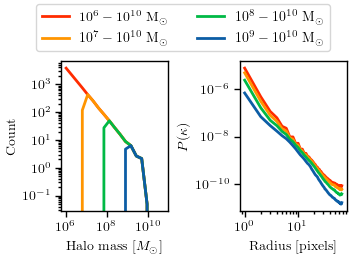

In [16]:
f, ax = plt.subplots(1, 2, figsize=(3.5, 2), constrained_layout=True)
std_alpha = 0.2

ax[0].loglog(bins_cdm_shmf, mean_cdm_shmf, alpha=1., color='C3', label=r'$10^{6}-10^{10}$ M$_{\odot}$')
# ax[0].fill_between(bins_cdm_shmf, mean_cdm_shmf - std_cdm_shmf, mean_cdm_shmf + std_cdm_shmf, alpha=std_alpha, color='C3')
ax[0].loglog(bins_sdm_shmf, mean_sdm_shmf, alpha=1., color='C2', label=r'$10^{7}-10^{10}$ M$_{\odot}$')
# ax[0].fill_between(bins_sdm_shmf, mean_sdm_shmf - std_sdm_shmf, mean_sdm_shmf + std_sdm_shmf, alpha=std_alpha, color='C2')
ax[0].loglog(bins_mdm_shmf, mean_mdm_shmf, alpha=1., color='C1', label=r'$10^{8}-10^{10}$ M$_{\odot}$')
# ax[0].fill_between(bins_mdm_shmf, mean_mdm_shmf - std_mdm_shmf, mean_mdm_shmf + std_mdm_shmf, alpha=std_alpha, color='C1')
ax[0].loglog(bins_wdm_shmf, mean_wdm_shmf, alpha=1., color='C0', label=r'$10^{9}-10^{10}$ M$_{\odot}$')
# ax[0].fill_between(bins_wdm_shmf, mean_wdm_shmf - std_wdm_shmf, mean_wdm_shmf + std_wdm_shmf, alpha=std_alpha, color='C0')
ax[0].set_xlabel('Halo mass [' + r'$M_{\odot}$]')
ax[0].set_xticks([1e6, 1e8, 1e10])
ax[0].set_ylabel('Count')

ax[1].loglog(kappa_r, mean_kappa_ps_cdm, alpha=1., color='C3', label='')
# ax[1].fill_between(kappa_r, mean_kappa_ps_cdm - std_kappa_ps_cdm, mean_kappa_ps_cdm + std_kappa_ps_cdm, alpha=std_alpha, color='C2')
ax[1].loglog(kappa_r, mean_kappa_ps_sdm, alpha=1., color='C2', label='')
# ax[1].fill_between(kappa_r, mean_kappa_ps_sdm - std_kappa_ps_sdm, mean_kappa_ps_sdm + std_kappa_ps_sdm, alpha=std_alpha, color='C3')
ax[1].loglog(kappa_r, mean_kappa_ps_mdm, alpha=1., color='C1', label='')
# ax[1].fill_between(kappa_r, mean_kappa_ps_mdm - std_kappa_ps_mdm, mean_kappa_ps_mdm + std_kappa_ps_mdm, alpha=std_alpha, color='C1')
ax[1].loglog(kappa_r, mean_kappa_ps_wdm, alpha=1., color='C0', label='')
# ax[1].fill_between(kappa_r, mean_kappa_ps_wdm - std_kappa_ps_wdm, mean_kappa_ps_wdm + std_kappa_ps_wdm, alpha=std_alpha, color='C0')
ax[1].set_xlabel('Radius [pixels]')
ax[1].set_ylabel(r'$P(\kappa)$')

handles_subs, labels_subs = ax[0].get_legend_handles_labels()
f.legend(handles_subs, labels_subs, loc='upper center', ncols=2, bbox_to_anchor=(0.52, 1.3))

plt.savefig(os.path.join(figure_dir, 'power_spectra.png'), dpi=1200)
plt.show()